In [76]:
from ResearchMain import *

## 数据准备

### 演示数据集
泰坦尼克号数据结构分析：
- Pclass:乘客所持票类，有三种值(1：lower,2：middle,3：upper)
- Survived:0代表死亡，1代表存活
- Name:乘客姓名
- Sex:乘客性别(男：1，女：0)
- Age:乘客年龄(缺失值取平均值)
- SibSp:乘客兄弟姐妹/配偶的个数(整数值)
- Parch:乘客父母/孩子的个数(整数值)
- Ticket:票号(字符串)
- Fare:乘客所持票的价格(浮点数，0-500不等)
- Cabin:乘客所在船舱
- Embark:乘客登船港口:S、C、Q

In [77]:
# 读取演示数据集
demo_data_name = 'pca_demo_titanic.csv'
demo_data = pd.read_csv(DATA_PATH + demo_data_name, index_col='PassengerId')
# data.head(3)

In [78]:
# data = demo_data

### 读取分析数据

In [79]:
# data =
data = all_df[[i for i in all_df.columns if
               isinstance(i, str) and i.startswith('S')]]

data = data.drop(['S-Size-d((0.9-0.1)/0.5)', 'S-pH'], axis=1)
data

,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9)
D-N1,705,806.285714,11.777,38.340,257.008
D-N2,320,794.285714,45.008,807.765,1239.506
D-N3,420,791.000000,611.957,875.213,1252.883
D-N4,650,768.000000,20.270,53.408,181.770
D-N5,1475,797.714286,9.567,40.619,116.947
...,...,...,...,...,...
W-H8,5325,956.571429,13.179,54.533,177.715
W-H9,5655,924.000000,12.406,46.868,175.772
W-H10,4060,901.142857,12.816,45.730,169.597
W-H11,4060,998.285714,13.281,56.314,187.891


In [80]:
data = data.replace(0, 0.00001)
data

,S-TN,S-TP,S-Size-d(0.1),S-Size-d(0.5),S-Size-d(0.9)
D-N1,705,806.285714,11.777,38.340,257.008
D-N2,320,794.285714,45.008,807.765,1239.506
D-N3,420,791.000000,611.957,875.213,1252.883
D-N4,650,768.000000,20.270,53.408,181.770
D-N5,1475,797.714286,9.567,40.619,116.947
...,...,...,...,...,...
W-H8,5325,956.571429,13.179,54.533,177.715
W-H9,5655,924.000000,12.406,46.868,175.772
W-H10,4060,901.142857,12.816,45.730,169.597
W-H11,4060,998.285714,13.281,56.314,187.891


In [81]:
gene_abundance_remove = gene_abundance.drop(['Bacterial 16S rRNA', 'Archaeal 16S rRNA'], axis=1)
data = gene_abundance_remove
data

Gene,AOA_amoA,AOB_amoA,nxrA,narG,napA,nirK,nirS,nosZ,cnorB,hzsA,hzsB,hzo,nifH
ID,,,,,,,,,,,,,
D-H1,1.309203e+07,362167.371442,7.557514e+06,6.193215e+05,2.714383e+06,6.208402e+05,7.556193e+07,1.101283e+06,2.877926e+05,6.900954e+05,9.771719e+05,59763.803097,1.330116e+04
D-H2,1.176137e+07,369272.095555,5.529952e+06,5.628594e+05,1.209347e+06,7.747804e+05,1.609800e+08,4.226340e+05,1.283924e+05,1.647053e+06,8.417798e+05,58386.778515,1.287674e+04
D-H3,6.728205e+06,487645.491524,1.466007e+07,2.953696e+05,8.957945e+05,4.032794e+05,4.983680e+08,8.871942e+05,1.290810e+05,1.504869e+06,1.353839e+06,48393.786152,9.917281e+03
D-H4,1.714973e+07,522516.452775,1.169370e+07,5.224020e+04,6.382258e+05,3.668576e+05,1.643910e+08,3.468487e+05,1.693446e+05,7.444430e+05,3.205211e+05,34202.593594,2.046502e+04
D-H5,1.210502e+07,562590.301880,1.201148e+07,7.642274e+04,1.929301e+05,8.655376e+05,3.047211e+08,8.382781e+05,1.602435e+05,9.150162e+05,2.760314e+05,32529.196754,1.908557e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
W-P5,4.467447e+07,533952.013512,2.635662e+09,5.189513e+05,2.841631e+06,3.023162e+07,8.470736e+07,2.139064e+08,6.096623e+05,2.120688e+06,4.861860e+06,368617.165021,6.576618e+05
W-P6,3.038296e+07,358944.921991,4.657828e+09,4.436650e+05,9.169049e+06,1.379646e+07,5.604978e+07,3.832982e+08,8.235145e+05,3.936532e+06,2.898582e+06,219426.589483,1.182591e+06
W-P7,1.133204e+07,387550.695182,4.406424e+09,3.765749e+06,2.165217e+06,7.350488e+06,7.570608e+07,6.144403e+07,1.381359e+06,5.360496e+06,1.478238e+07,286465.334411,2.124679e+06


## PCA分析

注意点：

1. 上面经过数据准备后，最后进行PCA分析的数据矩阵应命名为df；
2. 数据表不可以有空值；

### 预检验

首先进行KMO和Bartlett的检验，判断是否可以进行主成分分析。 对于KMO值：0.8上非常合适做主成分分析，0.7-0.8之间一般适合，0.6-0.7之间不太适合，0.5-0.6之间表示差，0.5下表示极不适合，对于 Bartlett的检验（p < 0.05,严格来说p < 0.01），若显著性小于0.05或0.01，拒绝原假设，则说明可以做主成分分析，若不拒绝原假设，则说明这些变量可能独立提供一些信息，不适合做主成分分析；

In [82]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# 巴特利特P值小于0.01，KMO值大于0.6；说明此数据适合做因子分析。
chi_square_value, p_value = calculate_bartlett_sphericity(data)  # 计算巴特利特P值
p_value

1.3824715070144277e-94

In [83]:
# data.isna()

In [84]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(data)
kmo_model

0.8029308507179285

<AxesSubplot:xlabel='Gene', ylabel='Gene'>

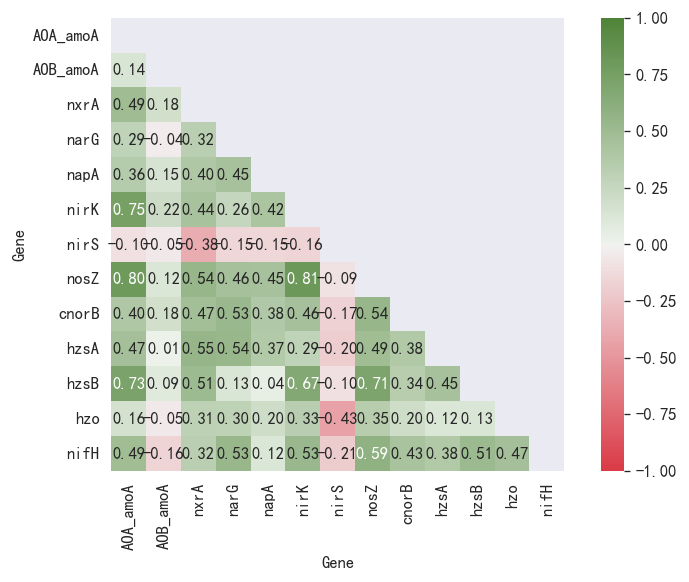

In [85]:
# 查看数据各列之间的相关性
matrix = data.corr()  # 获取各列之间的相关性，这个matrix其实就是X的协方差矩阵
mask = np.triu(np.ones_like(matrix, dtype=bool))  # mask掉上三角部分
plt.figure(figsize=(8, 5), dpi=120)
cmap = sns.diverging_palette(370, 120, n=80, as_cmap=True)
sns.heatmap(matrix, mask=mask, center=0, cmap=cmap, annot=True,
            square=True, fmt='.2f', vmax=1, vmin=-1)
# plt.title('泰坦尼克号数据集各列之间的相关性')

### 数据标准化

In [86]:
# 数据矩阵标准化与中心化
X = (data - data.mean()) / data.std(ddof=0)

这一步是主成分分析（PCA）的数据预处理，首先计算出矩阵中每一列的平均值，然后让每一列中的每一个元素都减去该列的平均值。在进行完这一步之后可以观察每一列数据的分散情况，如果列与列之间的差距仍过大，可以再计算出每一列的方差，然后再将减去平均值后的结果除以每一列的方差（这一步是可选步骤，叫做方差归一化）。

如果两步都做了，这个叫做数据的normalization——对一个非标准的正态分布随机变量转化为标准的正态分布随机变量。

这里一个注意点：
我们使用ddof=1样本标准偏差或ddof=0总体标准偏差作为参数来控制。

### 算法降维处理
在选取特征值的时候，要选取比较大的，特征值大的话数据方差就大，这也就意味着在经过降维后，可以最大程度上保留数据的差异性。

降维的过程实际就是寻找投影方向的过程。

从一个方面讲:

- 好的投影方向，可以使得投影误差最小化。
- 投影误差是各个数据点到投影点距离，这也就意味着经过降维处理后的损失达到最小。

从另一个方面讲:

- 好的投影方向，也就意味着在该方向投影的方差应该最大(分散度/区分度高)，可是使得信息在最大程度上得到保留。
- 复原误差小、重建容易。

降维的步骤：

目标：将n维数据降低为k维(k<n)。
（1）计算协方差矩阵：协方差矩阵（n×n）其实就是原数据矩阵中每两列之间的相关性系数；
（2）计算投影方向：对E进行奇异值分解(Singular Value Decomposition) [U,S,V] = svd (SIGMA)

其中U是一个nxn的矩阵，它每列是SIGMA的一个特征向量(线性代数概念)，U的前k列就是PCA的前k个投影向;我们将U的前k列记为投影矩阵P.
U的每一列都是一个特征向量，因此它的模长都为1，且特征向量之间都是正交的，乘积都为0

计算投影：

- 上一步我们得到了投影矩阵$P \in R^{n \times k}$；
- 对于第i个n维样本$x^{(i)}$，计算$z^{(i)} = x^{(i)} * P$，$z^{(i)}$就是降维后的第i个样本。

$$
X \in R^{m \times n} \times P \in R^{n \times k} = Z \in R^{m \times k}
$$


In [87]:
# SIGMA  # 各列之间的相关性（可以查看上面使用X.corr()命令获取矩阵X中各列之间的相关性所绘制的热图中的数据其实就是计算了矩阵X的协方差）
# 计算协方差矩阵（代表原矩阵中各列之间的相关性），@用来计算矩阵之间的乘法，.shape[0]获取矩阵中有多少行
SIGMA = (X.T @ X) / X.shape[0]
# 奇异值分解
U, S, V = np.linalg.svd(SIGMA)  # S 是个对角矩阵，是特征值，U是特征值对应的标准正交特征向量
# U
P = U[:, :2]  # 这里取U的前两列就是前两个投影的方向
# P
Z = X @ P  # Z就是经过降维后的矩阵
# Z

In [88]:
X = (data - data.mean()) / data.std(ddof=0)  # 获取经过Normalization的矩阵X
SIGMA = (X.T @ X) / X.shape[0]

# X.corr()
SIGMA  # SIGMA其实就是X.corr()

Gene,AOA_amoA,AOB_amoA,nxrA,narG,napA,nirK,nirS,nosZ,cnorB,hzsA,hzsB,hzo,nifH
Gene,,,,,,,,,,,,,
AOA_amoA,1.000000,0.140168,0.492490,0.291437,0.355824,0.746813,-0.100629,0.797589,0.398243,0.465391,0.726341,0.157519,0.490089
AOB_amoA,0.140168,1.000000,0.181314,-0.035243,0.146511,0.216426,-0.047537,0.123444,0.181380,0.013564,0.090571,-0.049301,-0.162783
nxrA,0.492490,0.181314,1.000000,0.320780,0.395276,0.439847,-0.380117,0.543527,0.473512,0.548381,0.507591,0.307073,0.321699
narG,0.291437,-0.035243,0.320780,1.000000,0.446148,0.262968,-0.147568,0.456699,0.530790,0.535580,0.127958,0.297805,0.532298
napA,0.355824,0.146511,0.395276,0.446148,1.000000,0.420775,-0.151117,0.450676,0.384255,0.367501,0.041296,0.202505,0.121056
nirK,0.746813,0.216426,0.439847,0.262968,0.420775,1.000000,-0.160111,0.812876,0.457544,0.294072,0.667120,0.331704,0.527738
nirS,-0.100629,-0.047537,-0.380117,-0.147568,-0.151117,-0.160111,1.000000,-0.088704,-0.172785,-0.201187,-0.099716,-0.433234,-0.210622
nosZ,0.797589,0.123444,0.543527,0.456699,0.450676,0.812876,-0.088704,1.000000,0.543715,0.490807,0.705947,0.348849,0.586964
cnorB,0.398243,0.181380,0.473512,0.530790,0.384255,0.457544,-0.172785,0.543715,1.000000,0.382483,0.344754,0.199498,0.433663


In [89]:
# V
# ew, ev = np.linalg.eig(X.T.dot(X))
ew, ev = np.linalg.eig(np.cov(X.T))  # ew: 特征值，ev: 特征向量
ew_order = np.argsort(ew)[::-1]  # 将ew按照从大到小的顺序排列
# 特征根，主要是看主成分对于变量解释的贡献率（可以理解为究竟需要多少主成分才能把变量表达为100%），一般都要表达到90%以上才可以，否则就要调整因子数据。
ew_sort = ew[ew_order]
ev_sort = ev[:, ew_order]
# print(ew_sort)

### 方差解释表格
**图表说明:**
上表为总方差解释表格，主要是看主成分对于变量解释的贡献率（可以理解为究竟需要多少主成分才能把变量表达为100%），一般都要表达到90%以上才可以，否则就要调整因子数据。一般情况下,方差解释率越高，说明该主成分越重要，权重占比也应该越高。

方差解释表中，在主成分4时，总方差解释的特征根低于1，变量解释的贡献率达到74.899%，以上仅为参考。
若特征根小于1临界值过大，也可以集合具体情况具体分析。

In [106]:
# 输出一个方差解释表格
var_inter_0 = pd.DataFrame({'特征值': ew_sort})  # 添加特征值列
var_inter_0['百分比'] = (var_inter_0 / var_inter_0.sum())  # 添加百分比列
var_inter_0['累计百分比'] = var_inter_0['百分比'].cumsum()  # 计算累计百分比
var_inter = var_inter_0.copy()
var_inter[['百分比', '累计百分比']] = var_inter[['百分比', '累计百分比']
]  # 保留一位小数
# var_inter_0['1'] = 1  # 前两列特征值大于1，且51%以上可以用来解释原来7个变量，因此取前两列
# var_inter[['累计百分比']] = var_inter[['累计百分比']].applymap(lambda x: format(x, '.1%'))
var_inter

,特征值,百分比,累计百分比
0,5.523325,0.420150,0.420150
1,1.536326,0.116866,0.537016
2,1.310593,0.099695,0.636711
3,1.181655,0.089887,0.726597
4,0.914082,0.069533,0.796130
5,0.732716,0.055737,0.851867
6,0.521807,0.039693,0.891560
7,0.454658,0.034585,0.926145
8,0.272451,0.020725,0.946870
9,0.236691,0.018005,0.964874


In [91]:
var_inter_0.to_clipboard()

In [93]:
# ev_sort[:, :2]  # 前两列就很大程度上可以用来解释原来7个变量，因此取前两列# V
V = ev_sort[:, :2]  # 前两列就很大程度上可以用来解释原来7个变量，因此取前两列

### 因子数据表

In [94]:
# 构建一个因子数据表
factor_load_table = pd.DataFrame(V)  # 因子载荷数据表，可以分析到每个主成分中隐变量的重要性。
factor_load_table.index = data.columns
factor_load_table.columns = ['PCA 0', 'PCA 1']
factor_load_table.index.name = 'var'
factor_load_table['公共度'] = factor_load_table['PCA 0'] ** 2 + factor_load_table[
    'PCA 1'] ** 2  # 公因子方差：每个变量对应的PCA0与PCA1的平方和
factor_load_table = factor_load_table
factor_load_table

,PCA 0,PCA 1,公共度
var,,,
AOA_amoA,0.344697,0.317227,0.219449
AOB_amoA,0.063296,0.260184,0.071702
nxrA,0.306017,-0.066204,0.098029
narG,0.255877,-0.378970,0.209092
napA,0.225720,-0.174893,0.081537
nirK,0.345649,0.244339,0.179175
nirS,-0.133881,0.433491,0.205839
nosZ,0.384156,0.175450,0.178358
cnorB,0.288519,-0.094958,0.092260


In [95]:
# U的每一列都是一个特征向量，因此它的模长都为1，且特征向量之间都是正交的，乘积都为0
# (factor_load_table['PCA 0'] * factor_load_table['PCA 1']).sum()  # 两个特征向量的乘积应为0
# (factor_load_table['PCA 0']**2).sum()  # 每一个特征向量的模长都为0
# (factor_load_table['PCA 1']**2).sum()

<AxesSubplot:ylabel='var'>

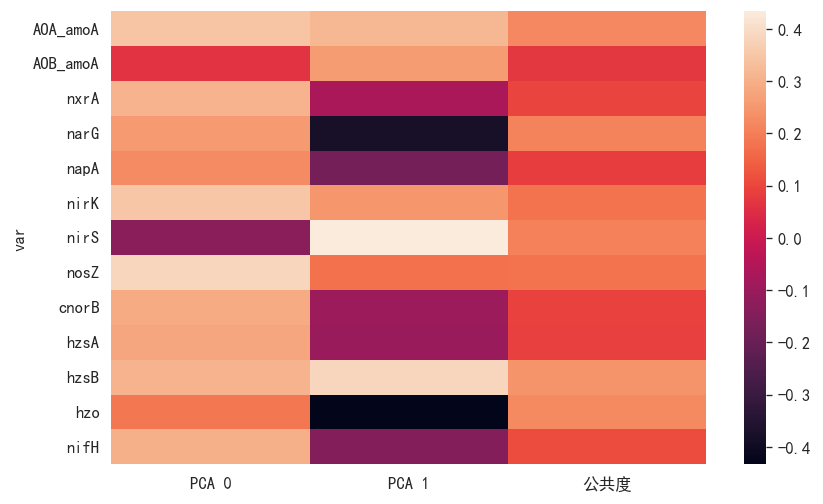

In [96]:
plt.figure(figsize=(8, 5), dpi=120)
sns.heatmap(factor_load_table)

### 绘图可视化

In [97]:
# X_new
X_new = X.dot(V)
# 将生存数据添加到DATaFrame中，用于绘制散点图的时候可以区分死亡与生存的区别
# X_new['Survived'] = train_data_0['Survived']
X_new

,0,1
ID,,
D-H1,-2.258209,0.030599
D-H2,-2.546645,0.482936
D-H3,-3.102126,2.206868
D-H4,-2.474914,1.033470
D-H5,-2.759804,1.668495
...,...,...
W-P5,0.707361,0.645814
W-P6,1.046843,-0.269898
W-P7,0.808801,-1.124603


<AxesSubplot:xlabel='PCA 0', ylabel='PCA 1'>

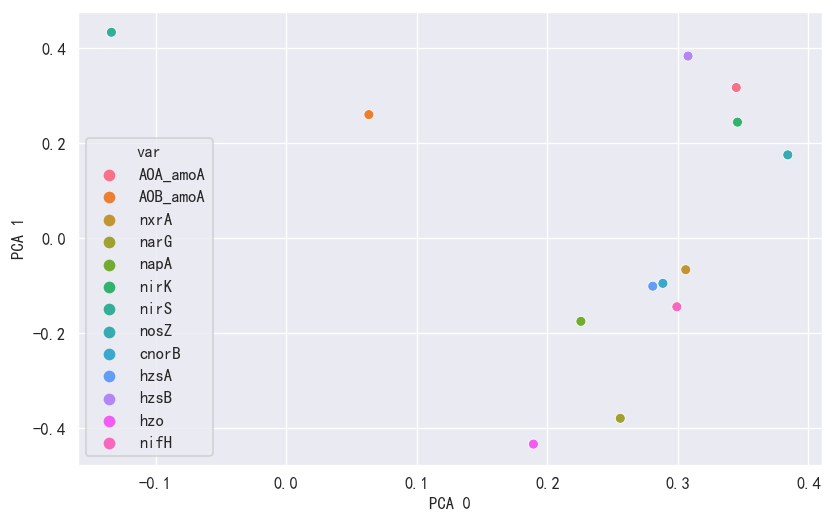

In [98]:
plt.figure(figsize=(8, 5), dpi=120)  # 设置绘图尺寸
sns.scatterplot(x=factor_load_table['PCA 0'],
                y=factor_load_table['PCA 1'], hue=factor_load_table.index)

In [99]:
# scatter
# plt.figure(figsize=(8, 5), dpi=120)  # 设置绘图尺寸
# sc_survived = plt.scatter(X_new[X_new['Survived'] == 1].iloc[:, 0], X_new[X_new['Survived'] == 1].iloc[:, 1], s=5,
#                           c='blue',
#                           cmap=plt.cm.coolwarm)  # 提取生存的
# sc_un_survived = plt.scatter(X_new[X_new['Survived'] == 0].iloc[:, 0], X_new[X_new['Survived'] == 0].iloc[:, 1], s=5,
#                              c='red',
#                              cmap=plt.cm.coolwarm)  # c=train_X0.Survived设置颜色反应生还状态，是死是活
# # plt.grid(False)  # 是否显示网格线
# plt.xlabel('PCA 0')  # 设置X、Y轴坐标名称
# plt.ylabel('PCA 1')
# plt.legend(handles=[sc_survived, sc_un_survived],
#            labels=['生存', '死亡'], loc='upper left')

### 成分矩阵表

In [100]:
# 成分矩阵表
composition_matrix = factor_load_table.loc[:, ['PCA 0', 'PCA 1']]  # 成分矩阵表 = 因子载荷数据表/对应每一个特征值
composition_matrix['PCA 0'] = composition_matrix['PCA 0'] / ew_sort[0]  # 这里有个问题，有的软件里除的是根号下特征值，有的没有
composition_matrix['PCA 1'] = composition_matrix['PCA 1'] / ew_sort[1]
composition_matrix.round(3)

,PCA 0,PCA 1
var,,
AOA_amoA,0.062,0.206
AOB_amoA,0.011,0.169
nxrA,0.055,-0.043
narG,0.046,-0.247
napA,0.041,-0.114
nirK,0.063,0.159
nirS,-0.024,0.282
nosZ,0.070,0.114
cnorB,0.052,-0.062


图表说明：
上表为成分矩阵表，意在说明各个成分的所包含的因子得分系数（主成分载荷），用于计算出成分得分，得出因子公式，其计算公式为：线性组合系数*（方差解释率/累积方差解释率），最后将其归一化即为因子权重分。
线性组合系数，公式为：因子载荷系数除以对应特征根，即成分矩阵的系数。
智能分析：
模型的公式：
F1=-0.389×Pclass-0.254×Sex+0.099×Age+0.14×SibSp+0.214×Parch+0.45×Fare-0.212×Embarked
F2=0.262×Pclass-0.166×Sex-0.382×Age+0.411×SibSp+0.392×Parch-0.038×Fare+0.127×Embarked
由上可以得到：
F=(0.265/0.511)×F1+(0.245/0.511)×F2

### 因子权重分析表

In [101]:
factor_weight_analysis = pd.DataFrame(var_inter_0.loc[:1, ['百分比', '累计百分比']])
factor_weight_analysis['权重'] = factor_weight_analysis['百分比'] / factor_weight_analysis['百分比'].sum()
factor_weight_analysis.index = ['PCA 0', 'PCA 1']
factor_weight_analysis.index.name = '主成分'
(factor_weight_analysis * 100).round(1).astype(str) + '%'  # 以保留一位小数、百分比的形式显示

,百分比,累计百分比,权重
主成分,,,
PCA 0,42.0%,42.0%,78.2%
PCA 1,11.7%,53.7%,21.8%


### 综合得分表（其实就是X_new中的数据）

In [102]:
comprehensive_score = pd.DataFrame(X_new.iloc[:, [0, 1]])
comprehensive_score.columns = ['PCA 0', 'PCA 1']
comprehensive_score['综合得分'] = comprehensive_score.iloc[:, 0] * factor_weight_analysis.loc[
    'PCA 0', '百分比'] + comprehensive_score.iloc[:, 1] * factor_weight_analysis.loc['PCA 1', '百分比']
comprehensive_score.sort_values(by='综合得分', ascending=False)  # 按照综合得分列倒序排列

,PCA 0,PCA 1,综合得分
ID,,,
W-H12,8.238368,5.573059,4.112653
W-H8,5.333101,2.465378,2.528823
W-H10,4.876082,3.143086,2.416007
W-H11,5.083574,1.580759,2.320602
W-H2,5.510466,-1.998822,2.081631
...,...,...,...
D-N2,-2.728359,1.536330,-0.966777
D-N3,-2.700036,1.102189,-1.005613
D-H2,-2.546645,0.482936,-1.013535


In [103]:
comprehensive_score.to_clipboard()

In [104]:
data.loc[comprehensive_score.sort_values(
    by='综合得分', ascending=False).head(5).index]  # 获取综合得分前五的人员

var,AOA_amoA,AOB_amoA,nxrA,narG,napA,nirK,nirS,nosZ,cnorB,hzsA,hzsB,hzo,nifH
ID,,,,,,,,,,,,,
W-H12,9.385959e+07,746056.658582,4.734639e+09,1.045151e+06,3.113340e+06,1.233494e+08,7.326213e+07,1.069002e+09,7.851958e+05,1.425564e+07,9.928910e+07,280759.115922,3.421028e+06
W-H8,7.468539e+07,292694.160549,4.418316e+09,1.857077e+06,4.228224e+06,3.455924e+07,9.231036e+07,8.684252e+08,1.027672e+06,1.819500e+07,8.110777e+07,245282.493249,2.834925e+06
W-H10,7.328582e+07,615337.809914,4.666949e+09,9.620983e+05,4.403474e+06,2.686501e+07,9.518481e+07,8.536139e+08,4.550655e+05,1.879367e+07,7.976105e+07,251205.893916,2.930613e+06
W-H11,7.064787e+07,487954.228922,5.364548e+09,7.454658e+05,3.090290e+06,2.896472e+07,7.285221e+07,3.245037e+08,1.317855e+06,1.417144e+07,7.721460e+07,396849.270123,5.536496e+06
W-H2,5.512611e+07,483165.864651,6.156601e+09,1.633959e+07,1.464840e+07,1.616070e+07,5.911295e+07,6.588847e+08,1.389965e+06,2.314928e+07,1.585689e+07,409339.111441,1.864466e+06
